# QuTiP Sandbox
_Will Kaufman, October 2020_

Just playing around!

Docs [here](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html).

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

## Kets and expectation values

In [2]:
spin = basis(2, 0)
spin

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

In [3]:
expect(sigmaz(), spin)

1.0

In [4]:
expect(sigmax(), spin)

0.0

## Spin System

In [66]:
N = 4

In [3]:
I_x = sum([
    tensor(  # I_x^i
        [identity(2)]*i
        + [sigmax()]
        + [identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_y = sum([
    tensor(  # I_x^i
        [identity(2)]*i
        + [sigmay()]
        + [identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_z = sum([
    tensor(  # I_x^i
        [identity(2)]*i
        + [sigmaz()]
        + [identity(2)]*(N-i-1)
    )
    for i in range(N)
])

In [67]:
chemical_shift = np.random.normal(scale=1e2, size=(N,))
dipolar_couplings = np.triu(np.random.normal(scale=1e0, size=(N, N)))

In [68]:
H_cs = sum([
    tensor([identity(2)]*i
           + [chemical_shift[i] * sigmaz()]
           + [identity(2)]*(N-i-1))
    for i in range(N)
])

In [69]:
H_dip = sum([
    dipolar_couplings[i, j]
    * (2 * tensor(  # I_z^i I_z^j
        [identity(2)]*i
        + [sigmaz()]
        + [identity(2)]*(j-i-1)
        + [sigmaz()]
        + [identity(2)]*(N-j-1)
    )
    - tensor(  # I_x^i I_x^j
        [identity(2)]*i
        + [sigmax()]
        + [identity(2)]*(j-i-1)
        + [sigmax()]
        + [identity(2)]*(N-j-1)
    )
    - tensor(  # I_y^i I_y^j
        [identity(2)]*i
        + [sigmay()]
        + [identity(2)]*(j-i-1)
        + [sigmay()]
        + [identity(2)]*(N-j-1)
    ))
    for i in range(N) for j in range(i+1, N)
])

In [39]:
H_cx = I_x

In [40]:
H_cy = I_y

In [41]:
def H_cy_coeff(t, args):
    nutation_frequency = 1e3
    p1 = (t > 0) & (t < np.pi/(4 * nutation_frequency))
    p2 = (t > 3e-2) & (t < 3e-2 + np.pi/(2 * nutation_frequency))
    return nutation_frequency * (p1 + p2)

In [70]:
rho0 = tensor([thermal_dm(2, .1)]*4)

In [71]:
output = mesolve([H_cs, H_dip, [H_cy, H_cy_coeff]],
                 rho0=rho0, tlist=np.linspace(0, 1e-1, 100),
                 e_ops=[I_x, I_y, I_z]
                )

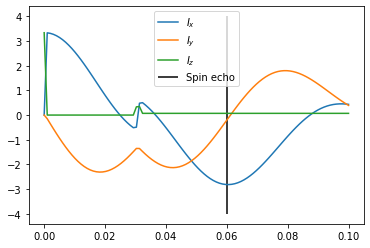

In [72]:
plt.plot(output.times, output.expect[0], label=r'$I_x$')
plt.plot(output.times, output.expect[1], label=r'$I_y$')
plt.plot(output.times, output.expect[2], label=r'$I_z$')
plt.vlines(0.06, -4, 4, color='black', label='Spin echo')
plt.legend()

## Magnus expansion

In [ ]:
# not sure how to apply time-dependent unitary operator to transform frame
# maybe use mesolve and have Hamiltonian be interaction Hamiltonian, and "density matrix" be operator to transform
# TODO make sure ^ is correct

## GRAPE and CRAB

Mess around here! Could be much quicker and better...